<center><h1> Wrangling and Analyzing @WeRateDogs Twitter Archive

<div style="text-align: right">
    Parth Thakur<br>
    11/09/2018<br>
    <a href=https://github.com/ParthThakur/Wrangling-and-Analyzing-WeRateDogs-twitter-archive>Github</a>
</div>

In this workbook, I will gather data on `@WeRateDogs` tweets. I willclean this daate and perform some analysis. <br>

`@WeRateDogs` is a twitter account that rates dog pictures and videos. I have the archive data for this account, but it comes with various tidyness and Quality issues. The archive is also missing some crucial features. The goal of this project is to identify as many issues as possible and rectify the. 

In [1]:
# Import required libraries.

%matplotlib inline

import numpy as np
import tweepy
import pandas as pd
import requests
import json
import re
import matplotlib.pyplot as plt

# Set font size at 15 for all plots.
plt.rcParams['font.size'] = 15 

In [2]:
# Setup twitter API

tw_keys = pd.read_json("../API keys.json").Twitter
auth = tweepy.OAuthHandler(tw_keys.consumer_key, tw_keys.consumer_secret)
auth.set_access_token(tw_keys.access_token, tw_keys.access_token_secret)

api = tweepy.API(auth,
                wait_on_rate_limit=True,
                wait_on_rate_limit_notify=True)

In [3]:
# Function to load additional tweet data using twitter API.

def get_tweet_data():
    failed_tweets = {}
    print("Querying Twitter API.")
    with open("tweet_json.txt", "w") as fw:        
        for tweet in tw_archive.tweet_id:
            try:
                twee = api.get_status(tweet, tweet_mode='extended')
            except tweepy.TweepError as e:
                print(tweet, "failed to load.")
                failed_tweets[tweet] = repr(e)
                continue
            fw.write(json.dumps(twee._json))
            fw.write('\n')

    return failed_tweets
            

# Function to read tweet_json.txt.

def read_tweet_json():
    tweet_info = []
    print("Trying to open tweet_json.txt")
    with open("tweet_json.txt", "r") as fr:
        print("File found.")
        for tweet in fr:
            twee = json.loads(tweet)
            retweet_count = twee["retweet_count"]
            favourite_count = twee["favorite_count"]
            if twee["full_text"][:4] == "RT @":
                tweet_type = "retweet"
            elif twee["full_text"][0] == "@":
                tweet_type = "reply"
            else:
                tweet_type = "original"
            tweet_info.append({"tweet_id": str(twee["id"]),
                              "retweet_count": int(retweet_count),
                              "favourite_count": int(favourite_count),
                              "tweet_type": tweet_type})
    tweet_info = pd.DataFrame(tweet_info, columns=["tweet_id", "retweet_count", "favourite_count", "tweet_type"])
    
    return tweet_info

In [4]:
# Class to embed tweets in the notebook.

class embed_tweet(object):
    def __init__(self, embed_code=None):
        self.embed_code = embed_code

    def _repr_html_(self):
        return self.embed_code

# Gather

Gathering all the required data programitacally. 

In [5]:
# Load the twitter archive data for @WeRateDogs.

tw_archive = pd.read_csv("twitter-archive-enhanced.csv") 

In [6]:
# Get "image_predictions.tsv" from Udacity's servers and load the data in a DataFrame

URL_predict = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
im_get = requests.get(URL_predict)
with open("image_predictions.tsv", "wb") as fw:
    fw.write(im_get.content)    

In [7]:
# Load image prediction Data from image_predictions.tsv

im_predict = pd.read_csv("image_predictions.tsv", delimiter="\t")

In [8]:
# Load additional tweet data from "tweet_json.txt".
try:
    tweet_info = read_tweet_json()
except FileNotFoundError:
    print("tweet_json.txt was not found.")
    failed_tweets = get_tweet_data()
    tweet_info = read_tweet_json()
    with open ("failed_tweets.json", "w") as fw:
        json.dump(failed_tweets, fw)

Trying to open tweet_json.txt
File found.



# Assess
Assessing the gathered data for quality, and tidyness issues.

I have three dasets loaded into pandas dataframes.
 - tw_archive which contains archive data for WeRateDogs twitter account.
 - im_predict which contains data on predicted dog species in the tweet.
 - tweet_info which contains additional data on the tweets.

In [9]:
tw_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [10]:
im_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [11]:
tw_archive.sample(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
687,788039637453406209,NaN,NaN,2016-10-17 15:31:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Did... did they pick out that license plate? 1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/788039637...,12,10,None,None,None,None,None
667,790337589677002753,NaN,NaN,2016-10-23 23:42:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Maggie. She can hear your cells divide. 1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/790337589...,12,10,Maggie,None,None,None,None
1010,747461612269887489,NaN,NaN,2016-06-27 16:08:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Never seen a shark hold another shark like thi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747461612...,10,10,None,None,None,None,None
669,790227638568808452,NaN,NaN,2016-10-23 16:25:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Leela. She's a Fetty Wo...,7.626999e+17,4.196984e+09,2016-08-08 17:19:51 +0000,https://twitter.com/dog_rates/status/762699858...,11,10,Leela,None,None,None,None
1764,678424312106393600,NaN,NaN,2015-12-20 03:58:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Crystal. She's a shitty fireman. No se...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678424312...,2,10,Crystal,None,None,None,None
1096,736365877722001409,NaN,NaN,2016-05-28 01:18:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rory. He's extremely impatient. 11/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/736365877...,11,10,Rory,None,None,pupper,None
354,831262627380748289,NaN,NaN,2017-02-13 22:03:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tucker. He's feeling h*ckin festive an...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/831262627...,12,10,Tucker,None,None,None,None
1610,685532292383666176,NaN,NaN,2016-01-08 18:43:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...","For the last time, WE. DO. NOT. RATE. BULBASAU...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/685532292...,9,10,None,None,None,None,None
787,774639387460112384,NaN,NaN,2016-09-10 16:03:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sprinkles. He's trapped in light jail....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/774639387...,10,10,Sprinkles,None,None,None,None
628,794926597468000259,NaN,NaN,2016-11-05 15:37:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mack. He's rather h*ckin sleepy. Excep...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/794926597...,12,10,Mack,None,None,None,None


In [12]:
im_predict.sample(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
1459,778027034220126208,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,clumber,0.946718,True,cocker_spaniel,0.015950,True,Lhasa,0.006519,True
297,671390180817915904,https://pbs.twimg.com/media/CVFBzpXVEAAHIOv.jpg,1,zebra,0.997673,False,tiger,0.000837,False,prairie_chicken,0.000575,False
802,691459709405118465,https://pbs.twimg.com/media/CZiO7mWUEAAa4zo.jpg,1,Shetland_sheepdog,0.551206,True,collie,0.232544,True,Border_collie,0.095218,True
1308,753655901052166144,https://pbs.twimg.com/media/CnWGCpdWgAAWZTI.jpg,1,miniature_pinscher,0.456092,True,toy_terrier,0.153126,True,Italian_greyhound,0.144147,True
561,677895101218201600,https://pbs.twimg.com/media/CWhd_7WWsAAaqWG.jpg,1,dalmatian,0.550702,True,kuvasz,0.060226,True,Great_Pyrenees,0.058631,True
1184,738883359779196928,https://pbs.twimg.com/media/CkEKe3QWYAAwoDy.jpg,2,Labrador_retriever,0.691137,True,golden_retriever,0.195558,True,Chesapeake_Bay_retriever,0.019585,True
390,673363615379013632,https://pbs.twimg.com/media/CVhEoq4WcAE8pBm.jpg,1,ox,0.193431,False,warthog,0.123827,False,bison,0.111177,False
1854,841077006473256960,https://pbs.twimg.com/media/C6wbE5bXUAAh1Hv.jpg,1,Brittany_spaniel,0.962985,True,Blenheim_spaniel,0.014820,True,clumber,0.009557,True
445,674646392044941312,https://pbs.twimg.com/media/CVzTUGrW4AAirJH.jpg,1,flat-coated_retriever,0.837448,True,groenendael,0.086166,True,Labrador_retriever,0.016052,True


In [13]:
tw_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [14]:
tw_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [15]:
tw_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

### Quality:

##### `tw_archive` table:
 - `rating_denominator` is not always 10.
 - `rating_numerator` is not always greater than 10.
 - `expanded_url` contain duplicate data sometimes.
 - `name` is sometimes missing or a preposition. _(Can't fix missing names.)_
 - `expanded_url` sometimes missing.
 - No column to determine type of tweet; i.e. Original, Retweet, or Reply.
 - `dog_stage` sometimes missing. _(Can't fix currently.)_
 - Some column headers aren't very descriptive.
 
 
##### `im_predict` table:
 - Underscore (\_) between words.
 - Some tweets contain no dogs.

### Tidiness:

##### `tw_archive` table:
 - Missing values are "None".
 - Single variable `dog_stage` in four seperate columns.
 - Multiple `dog_stage` in some tweets.
 - Short URL is in `text` column.
 - `source` has full links.
 - `tweet_id`, `timestamp`, `retweeted_status_timestamp` columns are int64.
 
##### `im_predict` table:
 - `p1`, `p2`, `p3`, are objects.

# Clean
Cleaning the issues found in the assessment section.

In [16]:
# Create copies of original dataset for cleaning.

tw_archive_clean = tw_archive.copy()
im_predict_clean = im_predict.copy()

##### Define:
`tweet_id` in both tables is `int64`. Since I am nott going to perform any mathematical operatioons on the, convert them to `str`.

##### Code:

In [17]:
tw_archive_clean.tweet_id = tw_archive_clean.tweet_id.astype("str")
im_predict_clean.tweet_id = im_predict_clean.tweet_id.astype("str")

##### Test:

In [18]:
tw_archive_clean.tweet_id.head(), im_predict_clean.tweet_id.head()

(0    892420643555336193
 1    892177421306343426
 2    891815181378084864
 3    891689557279858688
 4    891327558926688256
 Name: tweet_id, dtype: object, 0    666020888022790149
 1    666029285002620928
 2    666033412701032449
 3    666044226329800704
 4    666049248165822465
 Name: tweet_id, dtype: object)

### Missing data

`tw_archive` missing retweet count and favourite count.

##### Define:
The twitter-archive-enhanced.csv dataset did not have favourite count and retweet count for the tweet data. I gathered it using the Twitter API. Using the JSON data, I also determined if the tweet is an original, reply, or a retweet. <br>
Use `pandas.merge()` to mearge `tweet_info` with `tw_archive` to add this data to our dataset.


##### Code

In [19]:
tw_archive_clean = tw_archive_clean.merge(tweet_info, how="inner", on="tweet_id")

##### Test:

In [20]:
tw_archive_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favourite_count,tweet_type
1179,717428917016076293,NaN,NaN,2016-04-05 19:09:17 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Skittle. He's trying to communicate. 1...,NaN,NaN,NaN,https://vine.co/v/iIhEU2lVqxz,11,10,Skittle,None,None,None,None,488,1688,original
1467,693267061318012928,NaN,NaN,2016-01-30 02:58:42 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Oscar. He can wave. Friendly af. 12/10...,NaN,NaN,NaN,https://vine.co/v/i5n2irFUYWv,12,10,Oscar,None,None,None,None,889,2531,original
67,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None,6812,0,retweet
2267,667211855547486208,NaN,NaN,2015-11-19 05:24:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Genevieve. She is a golden retriever c...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667211855...,9,10,Genevieve,None,None,None,None,248,498,original
1839,675534494439489536,NaN,NaN,2015-12-12 04:35:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Seriously guys?! Only send in dogs. I only rat...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675534494...,11,10,a,None,None,None,None,445,1889,original
2018,671744970634719232,NaN,NaN,2015-12-01 17:37:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Very fit horned dog here. Looks powerful. Not ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671744970...,6,10,None,None,None,None,None,802,1382,original
646,791774931465953280,NaN,NaN,2016-10-27 22:53:48 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Vine will be deeply missed. This was by far my...,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,14,10,None,None,None,None,None,24722,48874,original
153,860981674716409858,NaN,NaN,2017-05-06 22:16:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Lorenzo. He's an avid nift...,8.605638e+17,4.196984e+09,2017-05-05 18:36:06 +0000,https://www.gofundme.com/help-lorenzo-beat-can...,13,10,Lorenzo,None,None,None,None,2225,0,retweet
1162,719704490224398336,NaN,NaN,2016-04-12 01:51:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Clyde. He's making sure you're having ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/719704490...,12,10,Clyde,None,None,pupper,None,1566,4809,original
112,870374049280663552,NaN,NaN,2017-06-01 20:18:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She really likes the planet. Wou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/870374049...,13,10,Zoey,None,None,None,None,26437,82628,original


### Tidiness

##### Define
The dataset contsins "none" as as string object for missing values. Replace "None" for missing values in `tw_archive` with `np.NaN`

##### Code:

In [21]:
tw_archive_clean.replace(to_replace="None", value=np.NaN, inplace=True)

##### Test:

In [22]:
tw_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favourite_count,tweet_type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN,8444,38429,original
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN,6224,32923,original
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN,4125,24810,original
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN,8578,41777,original
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN,9307,39942,original


##### Define:

Use pandas.melt function to get a single variable `dog_stage` from the four variables.

In [23]:
dog_stage_df = pd.melt(tw_archive_clean, id_vars=["tweet_id"], 
                    value_vars=["doggo", "floofer", "pupper", "puppo"],
                   value_name="dog_stage").dropna().drop("variable", axis=1)
tw_archive_clean = tw_archive_clean.merge(dog_stage_df, on="tweet_id", how="left")
tw_archive_clean.dog_stage = tw_archive_clean.dog_stage.astype('category')
tw_archive_clean.drop(["doggo", "floofer", "pupper", "puppo"], axis=1, inplace=True)


##### Test:

In [24]:
tw_archive_clean.dog_stage.value_counts()

pupper     255
doggo       96
puppo       30
floofer     10
Name: dog_stage, dtype: int64

##### Define:
Some tweets had multiple dog stages. This might have happened if the tweet contained two or more of the keywords. As it is very difficult to determine where in the text the original dog stage might occur, consider the first stage as true and discard duplicates.

##### Code:

In [25]:
tw_archive_clean.drop_duplicates(subset="tweet_id", inplace=True)

##### Test:

In [26]:
tw_archive_clean.duplicated(subset=["tweet_id"]).any()

False

##### Define:
Short URL is with tweet text. Use Regular expressions to remove it from the text column and create a new `short_URL` column.

##### Code

In [27]:
s_url = re.compile(r"(https://t.co/.{10})")
tw_archive_clean["short_url"] = tw_archive_clean.text.str.extract(s_url)
tw_archive_clean.text = tw_archive_clean.text.str.replace(s_url, "")

##### Test:

In [28]:
tw_archive_clean[["tweet_id", "short_url", "text"]].sample(10)

,tweet_id,short_url,text
39,884562892145688576,https://t.co/1r4MFCbCX5,This is Kevin. He's just so happy. 13/10 what ...
83,876484053909872640,https://t.co/26BXueUgbs,This is Benedict. He wants to thank you for th...
1851,675707330206547968,https://t.co/ALJvbtcwf0,We've got ourselves a battle here. Watch out R...
555,802624713319034886,https://t.co/SuXcI9B7pQ,"RT @dog_rates: ""Yep... just as I suspected. Yo..."
728,781524693396357120,https://t.co/ya7bviQUUf,Idk why this keeps happening. We only rate dog...
1700,680940246314430465,https://t.co/VQXdwJfkyS,This is Alice. She's an idiot. 4/10
980,749395845976588288,https://t.co/lznl6QGkYc,This is George. He just remembered that bees a...
943,752519690950500352,https://t.co/G54yClasz2,Hopefully this puppo on a swing will help get ...
2057,671347597085433856,https://t.co/svlkUlg3NH,This is Lola. She was not fully prepared for t...
1261,710140971284037632,https://t.co/nLuPY3pY12,This is Tater. His underbite is fierce af. Doe...


##### Define
Some columns in the tables are of incorrect datatypes. Correct them as follows: <br>

`tw_archive` table:<br>
 - `timestamp`: DateTime<br>
 - `retweeted_status_timestamp`: DateTime<br>
 
`im_predict` table:<br>
 - `p1`, `p2`, `p3`: Category

In [29]:
tw_archive_clean.timestamp = pd.to_datetime(tw_archive_clean.timestamp)
tw_archive_clean.retweeted_status_timestamp = pd.to_datetime(tw_archive_clean.retweeted_status_timestamp)

In [30]:
im_predict_clean.p1 = im_predict_clean.p1.astype('category')
im_predict_clean.p2 = im_predict_clean.p2.astype('category')
im_predict_clean.p3 = im_predict_clean.p3.astype('category')

##### Test:

In [31]:
tw_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2341 entries, 0 to 2354
Data columns (total 18 columns):
tweet_id                      2341 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2341 non-null datetime64[ns]
source                        2341 non-null object
text                          2341 non-null object
retweeted_status_id           167 non-null float64
retweeted_status_user_id      167 non-null float64
retweeted_status_timestamp    167 non-null datetime64[ns]
expanded_urls                 2282 non-null object
rating_numerator              2341 non-null int64
rating_denominator            2341 non-null int64
name                          1604 non-null object
retweet_count                 2341 non-null int64
favourite_count               2341 non-null int64
tweet_type                    2341 non-null object
dog_stage                     377 non-null category
short_url       

In [32]:
im_predict_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null category
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null category
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null category
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), category(3), float64(3), int64(1), object(2)
memory usage: 174.9+ KB


##### Define:
Source of the tweet has has the entire HTML tag. Remove the redundant tags and only keep the text. `source` is also not very descriptive, so change column name to `tweet_source`.

##### Code:

In [33]:
source_regex = re.compile(r">(.+)<")
tw_archive_clean["tweet_source"] = tw_archive_clean.source.str.extract(source_regex)
tw_archive_clean.drop("source", axis=1, inplace=True)

##### Test:

In [34]:
tw_archive_clean[["tweet_id", "tweet_source"]].sample(10)

,tweet_id,tweet_source
144,863079547188785154,Twitter for iPhone
2325,666411507551481857,Twitter for iPhone
890,759446261539934208,Twitter for iPhone
548,803773340896923648,Twitter for iPhone
742,780092040432480260,Twitter for iPhone
809,771136648247640064,Twitter for iPhone
806,771500966810099713,Twitter for iPhone
1511,691321916024623104,Twitter for iPhone
700,785639753186217984,Twitter for iPhone
2112,670434127938719744,Twitter for iPhone


### Quality

##### Define:
Some tweets have other fractions in the text. Use better regex to correct errors in rating_numerator and rating_denominator.

##### Code:

In [35]:
rating_num_regex = re.compile(r"(\d+\.?\d?)\/\d\d\d?")
rating_den_regex = re.compile(r"\d+\.?\d?\/(\d\d\d?)")
tw_archive_clean.rating_numerator = tw_archive_clean.text.str.extract(rating_num_regex).astype("int32", errors="ignore")
tw_archive_clean.rating_denominator = tw_archive_clean.text.str.extract(rating_den_regex).astype("int32", errors="ignore")


##### Test:

In [36]:
tw_archive_clean.rating_numerator.value_counts()

12      553
11      464
10      461
13      345
9       158
8       102
7        54
14       51
5        35
6        32
3        19
4        17
2         9
1         8
15        2
75        2
0         2
420       2
143       1
20        1
84        1
26        1
99        1
666       1
80        1
27        1
17        1
165       1
204       1
45        1
121       1
007       1
144       1
50        1
960       1
13.5      1
182       1
1776      1
9.5       1
60        1
44        1
88        1
Name: rating_numerator, dtype: int64

##### Define:
`name` is sometimes an article or a preposition. Replace these with blanks.<br>
`name` is also not a descriptive column header. Replace with `dog_name`.

##### Code

In [37]:
bad_dog_names = ["a", "with", "an", "the", "all", 'Hk']
dog_name_regex = r"(?:^|(?<= ))" + r'|'.join(bad_dog_names) + r"(?:(?= )|$)"
tw_archive_clean["dog_name"] = tw_archive_clean.name.str.replace(dog_name_regex, str(np.nan), regex=True)
tw_archive_clean.drop("name", axis=1, inplace=True) 

##### Test

In [38]:
tw_archive_clean.dog_name.isin(bad_dog_names).any()

False

##### Define:
`expanded_urls` sometimes have duplicated urls present seperated by commas. Since commas arent normally used in urls, everything after the comma, including it is deleted.

In [39]:
tw_archive_clean.iloc[4].expanded_urls

'https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1'

##### Code:

In [40]:
tw_archive_clean.expanded_urls = tw_archive_clean.expanded_urls.str.replace(r",.+", "", regex=True)

##### Test:


In [41]:
tw_archive_clean.iloc[4].expanded_urls

'https://twitter.com/dog_rates/status/891327558926688256/photo/1'

##### Define:
The `expanded_url` is missing for some tweets. Use the requests library to get the full URL of the tweet. The requests library will also handle any redirects that occur and give us the final URL.

##### Code:

In [42]:
null_expn_urls = tw_archive_clean[pd.isnull(tw_archive_clean.expanded_urls)]["tweet_id"].tolist()
t_url = r"https://twitter.com/dog_rates/status/"

for tweet in null_expn_urls:
    response = requests.get(t_url + str(tweet))
    tw_archive_clean.loc[tw_archive_clean["tweet_id"]==tweet, "expanded_urls"] = response.url

##### Test:

In [43]:
pd.isnull(tw_archive_clean.expanded_urls).any()

False

##### Define:
The words in `p1`, `p2`, `p3`, columns in `im_predict` table are seperated by underscores (\_). Replace the underscores with spaces. <br>
The first letters of each word should also be be capatalised for consistency.

In [44]:
tw_archive_clean.to_csv("twitter_archive_master.csv", index=False)

##### Code:

In [45]:
im_predict_clean.p1 = im_predict_clean.p1.str.replace(r"_", " ", regex=True).str.title()
im_predict_clean.p2 = im_predict_clean.p2.str.replace(r"_", " ", regex=True).str.title()
im_predict_clean.p3 = im_predict_clean.p3.str.replace(r"_", " ", regex=True).str.title()

##### Test:

In [46]:
im_predict_clean[["p1", "p2", "p3"]].sample(10)

,p1,p2,p3
628,Shetland Sheepdog,Collie,Pomeranian
220,German Short-Haired Pointer,Staffordshire Bullterrier,Bluetick
533,Hamster,Guinea Pig,Macaque
691,Llama,Ram,Hog
72,Golden Retriever,Labrador Retriever,Kuvasz
1884,Cardigan,Boston Bull,Doormat
143,Crash Helmet,Toaster,Mouse
934,Golden Retriever,Standard Poodle,Tibetan Mastiff
740,Seat Belt,Great Dane,Weimaraner
855,Car Mirror,Chesapeake Bay Retriever,Vizsla


##### Define:
Rating numerator for tweet_id 695064344191721472 and 722974582966214656 is 13 and not 4.

##### Code:

In [47]:
tw_archive_clean.loc[tw_archive_clean.tweet_id == "695064344191721472", "rating_numerator"] = 13
tw_archive_clean.loc[tw_archive_clean.tweet_id == "722974582966214656", "rating_numerator"] = 13

##### Test:

In [48]:
tw_archive_clean.loc[tw_archive_clean.tweet_id.isin(["695064344191721472", "722974582966214656"])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,retweet_count,favourite_count,tweet_type,dog_stage,short_url,tweet_source,dog_name
1164,722974582966214656,NaN,NaN,2016-04-21 02:25:47,Happy 4/20 from the squad! 13/10 for all,NaN,NaN,NaT,https://twitter.com/dog_rates/status/722974582...,13,20,1695,4340,original,NaN,https://t.co/eV1diwds8a,Twitter for iPhone,NaN
1458,695064344191721472,NaN,NaN,2016-02-04 02:00:27,This may be the greatest video I've ever been ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/695064344...,13,10,652,1706,original,NaN,https://t.co/uaJmNgXR2P,Twitter for iPhone,NaN


Going forward, I need a combined dataset of `tw_archive_clean` and `im_predict_clean`. There's also some columns in the `tw_archive_clean` dataset that arent necessary for our analysis. <br>
These columns are not necessarily useless, so I will first save the cleaned tables as csv files. While combining the datasets, I'd like to only get tweets that are of dogs. All other tweets are not needed and will be dropped.

In [49]:
tw_archive_clean.to_csv("twitter-archive-cleaned.csv", index=False)
im_predict_clean.to_csv("image-predictions-cleaned.csv", index=False)

In [50]:
tw_archive_clean = pd.read_csv("twitter-archive-cleaned.csv")
im_predict_clean = pd.read_csv("image-predictions-cleaned.csv")

##### Define:
The datasets contain columns that are not required for our analysis. I will drop all such columns.<br>
`tw_archive` table:
 - expanded_urls
 - in_reply_to_status_id
 - in_reply_to_user_id
 - rating_denominator
 - retweeted_status_id
 - retweeted_status_user_id
 - retweeted_status_timestamp
 - tweet_type
 - short_url
 - tweet_source
 
Also, any tweet that is not "original" is not required. Therefore drop all retweets and replies.

##### Code:

In [51]:
tw_archive_clean = tw_archive_clean[tw_archive_clean.tweet_type == "original"]
tw_archive_clean.drop(["expanded_urls",
                       "in_reply_to_status_id",
                       "in_reply_to_user_id",
                       "rating_denominator",
                       "retweeted_status_id",
                       "retweeted_status_user_id",
                       "retweeted_status_timestamp",
                       "tweet_type",
                       "short_url",
                       "tweet_source"], axis=1, inplace=True)


##### Test:

In [52]:
tw_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151 entries, 0 to 2340
Data columns (total 8 columns):
tweet_id            2151 non-null int64
timestamp           2151 non-null object
text                2151 non-null object
rating_numerator    2150 non-null float64
retweet_count       2151 non-null int64
favourite_count     2151 non-null int64
dog_stage           342 non-null object
dog_name            1431 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 151.2+ KB


##### Define
the im_predict table contain no dogs at all. 
The `im_predict` table contains predictions of dog breeds contained in the media. It also contains tweets with no dogs at all. As I am interested in dogs only, I will only add the dog breed with the highest confidence value; i.e. the p_conf values of each prediction.

##### Code:

In [53]:
im_predict_clean = im_predict_clean[im_predict_clean[["p1_dog", "p2_dog", "p3_dog"]].any(axis=1)]
dog_breed_list = []
for index, tweet in im_predict_clean.iterrows():
    if tweet.p1_dog:
        dog_breed = tweet.p1
        conf = tweet.p1_conf

    elif tweet.p2_dog:
        dog_breed = tweet.p2
        conf = tweet.p2_conf
        
    elif tweet.p3_dog:
        dog_breed = tweet.p3
        conf = tweet.p3_conf
        
    dog_breed_list.append({"tweet_id": tweet.tweet_id,
                           "dog_breed": dog_breed,
                           "breed_confidence": conf,
                           "jpg_url": tweet.jpg_url})
dog_breed_df = pd.DataFrame(dog_breed_list, columns=["tweet_id", "dog_breed", "breed_confidence", "jpg_url"])

##### Test

In [54]:
dog_breed_df.head(10)

,tweet_id,dog_breed,breed_confidence,jpg_url
0,666020888022790149,Welsh Springer Spaniel,0.465074,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
1,666029285002620928,Redbone,0.506826,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg
2,666033412701032449,German Shepherd,0.596461,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
3,666044226329800704,Rhodesian Ridgeback,0.408143,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
4,666049248165822465,Miniature Pinscher,0.560311,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
5,666050758794694657,Bernese Mountain Dog,0.651137,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg
6,666055525042405380,Chow,0.692517,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg
7,666057090499244032,Golden Retriever,0.007959,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg
8,666058600524156928,Miniature Poodle,0.201493,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg
9,666063827256086533,Golden Retriever,0.775930,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg


##### Define:
Create a `tw_archive_master` table with all the important columns. Use inner join on the `tw_archive` table and ``dog_breed_df` table

##### Code:

In [55]:
tw_archive_master = tw_archive_clean.merge(dog_breed_df, how="inner", on="tweet_id")
tw_archive_master.tweet_id = tw_archive_master.tweet_id.astype(str)
tw_archive_master = tw_archive_master[['timestamp',
                                       'dog_name', 
                                       'rating_numerator', 
                                       'dog_breed', 
                                       'dog_stage',
                                       'tweet_id',
                                       'text', 
                                       'retweet_count', 
                                       'favourite_count', 
                                       'breed_confidence', 
                                       'jpg_url']]

##### Test:

In [56]:
tw_archive_master.head()

,timestamp,dog_name,rating_numerator,dog_breed,dog_stage,tweet_id,text,retweet_count,favourite_count,breed_confidence,jpg_url
0,2017-08-01 00:17:27,Tilly,13.0,Chihuahua,NaN,892177421306343426,This is Tilly. She's just checking pup on you....,6224,32923,0.323581,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
1,2017-07-31 00:18:03,Archie,12.0,Chihuahua,NaN,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,4125,24810,0.716012,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
2,2017-07-30 15:58:51,Darla,13.0,Labrador Retriever,NaN,891689557279858688,This is Darla. She commenced a snooze mid meal...,8578,41777,0.168086,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
3,2017-07-29 16:00:24,Frnanklin,12.0,Basset,NaN,891327558926688256,This is Franklin. He would like you to stop ca...,9307,39942,0.555712,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
4,2017-07-29 00:08:17,NaN,13.0,Chesapeake Bay Retriever,NaN,891087950875897856,Here we have a majestic great white breaching ...,3085,20052,0.425595,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg


Saving the cleaned and combined data in a master csv file

In [57]:
tw_archive_master.to_csv("twitter_archive_master.csv", index=False, index_label=False)

This concludes the Data Wrangling process. I now have a dataframe with clean, tidy data which can be analysed without troubles.

# Analyze

I would first like to know the distribution for dog ratings.

In [58]:
df = pd.read_csv("twitter_archive_master.csv").set_index("tweet_id")
df.dog_stage = df.dog_stage.astype('category')
df.timestamp = pd.to_datetime(df.timestamp)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 892177421306343426 to 666020888022790149
Data columns (total 10 columns):
timestamp           1685 non-null datetime64[ns]
dog_name            1213 non-null object
rating_numerator    1684 non-null float64
dog_breed           1685 non-null object
dog_stage           260 non-null category
text                1685 non-null object
retweet_count       1685 non-null int64
favourite_count     1685 non-null int64
breed_confidence    1685 non-null float64
jpg_url             1685 non-null object
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 133.5+ KB


Let me first check some descriptive statistics on the important columns.

In [60]:
df.describe()

,rating_numerator,retweet_count,favourite_count,breed_confidence
count,1684.000000,1685.000000,1685.000000,1685.000000
mean,11.481295,2739.262315,9136.054599,0.549905
std,8.098699,4930.085162,13283.640276,0.299357
min,0.000000,12.000000,80.000000,0.000010
25%,10.000000,614.000000,2086.000000,0.302685
50%,11.000000,1369.000000,4294.000000,0.550506
75%,12.000000,3104.000000,11312.000000,0.822048
max,165.000000,84548.000000,164596.000000,0.999956


In [61]:
df.dog_name.value_counts().nlargest(5)

Lucy       10
Cooper     10
Oliver      9
Charlie     9
Tucker      9
Name: dog_name, dtype: int64

In [62]:
df.dog_breed.value_counts().nlargest(5)

Golden Retriever      158
Labrador Retriever    108
Pembroke               95
Chihuahua              91
Pug                    62
Name: dog_breed, dtype: int64

There are a few that things that become apparent here.

1. The five most common dog names are:
    - Cooper
    - Lucy
    - Charlie
    - Oliver
    - Tucker
    
    
2. The five most common dog breeds are:
    - Golden Retriever
    - Labrador Retriever
    - Pembroke
    - Chihuahua
    - Pug
    
    
3. There are a few outliers on in both rating numerator, rating denominator. 
   Most interestingly, there are a few ratings below 10.
   
4. Least amount of retweets are 12, while the maximum is 84,113.

5. Least amount of favourites is 80, while the maximum is 161,869.

### Some Questions:
    
    Why was a dog rated 0, and which dog got a rating of 165?
    Who is twitter's most favorite dog, and did it get the maximum retweets as 
    well?
    Which dog breed is Twitter's most favourite, and are they also rated the highest?

First let us take a look at the tweet which rated a dog 0.

In [63]:
# Get the html code to embed tweet using the oembed API from twitter.
# Then display the tweet as an html object using the embed_tweet class defined earlier.

dog0_index = df.loc[df.rating_numerator == 0].index.values[0]
dog0_tweet = requests.get("https://api.twitter.com/1.1/statuses/oembed.json?id=" + str(dog0_index)).json()["html"]
embed_tweet(dog0_tweet)

Looks like the tweet is about plagiarism, and no dogs have been given a rating 
of 0. <br>
Now, which dog has a rating of 165?

In [64]:
dog165_index = df.loc[df.rating_numerator == 165].index.values[0]
dog165_tweet = requests.get("https://api.twitter.com/1.1/statuses/oembed.json?id=" + str(dog165_index)).json()["html"]
embed_tweet(dog165_tweet)

Looks like it's a bunch of dogs at the ownwer's front door. Truely adorable and 
worthy of such a high rating!

Who is twitter's most favourite dog?


In [65]:
dog_favourite_index = df.loc[df.favourite_count == max(df.favourite_count)].index.values[0]
dog_favourite_tweet = requests.get("https://api.twitter.com/1.1/statuses/oembed.json?id=" + str(dog_favourite_index)).json()["html"]
embed_tweet(dog_favourite_tweet)

Did this dog also get the maximum retweets?

In [66]:
 (df.loc[df.favourite_count == max(df.favourite_count)].dropna(axis=1) == df.loc[df.retweet_count == max(df.retweet_count)].dropna(axis=1)).all(axis=1)

tweet_id
744234799360020481    True
dtype: bool

He is! What an adorable realisation indeed.

Let's check some relationships between the data. I'd like to know which breed of dog is favourited the most. To see this, I'll add the `favourite_count` for all breeds. As there are more than 100 breeds in the dataset, I'll only take a look at the top 10 most common breeds. The rest of the breeds will be tagged as `others`.

In [67]:
# Make new column in dataset to indicate top 10 most common breed.
# Then use the new column to get the sum of all other values grouped by the new catagories.

df.dog_breed = df.dog_breed.astype("category")
breed_top10 = df.dog_breed.value_counts().nlargest(10).index.tolist()
df["breed_top10"] = np.where(df.dog_breed.isin(breed_top10), df.dog_breed, "other")
df.breed_top10 = df.breed_top10.astype("category")

x = df.groupby("breed_top10").sum()  # `x` holds the "sum" dataset.
x.index.name = "Breeds"

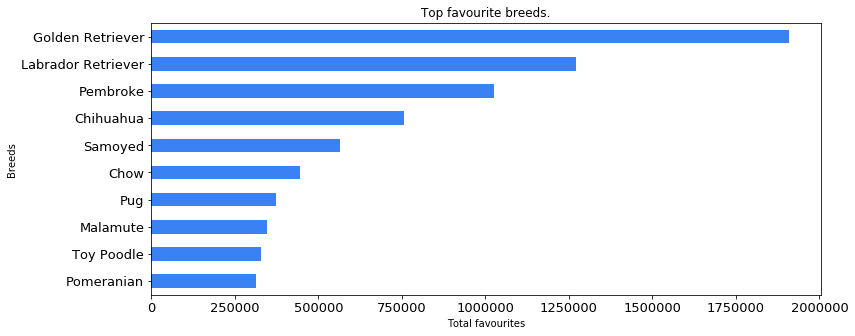

In [70]:
# Plot "sum of favourite_count" by "dog_breed". Sort the data to make the plot more readable.
# Dropped "other" category as the value will be large and skew the plot.

x.sort_values(by=["favourite_count"], inplace=True)
plt.xlabel("Total favourites")
x.drop("other")["favourite_count"].plot(kind="barh", color='#3A82F4', fontsize=13,
                          title="Top favourite breeds.",
                          figsize=(12,5))

It looks like Twitter likes Golden Retrievers the most with about 2,000,000 favourites, followed by Labrador Retrievers at around 1,500,000 favourites.

Finally, let me look at the top rated dogs.

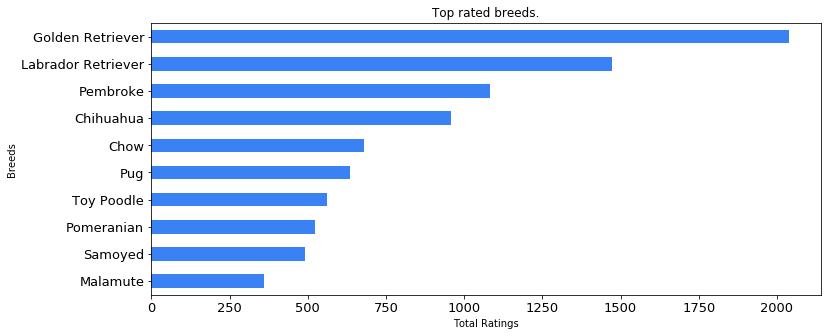

In [69]:
# Plot "sum of rating_numerator" vs "dog_breed".

x.sort_values(by=["rating_numerator"], inplace=True)
plt.xlabel("Total Ratings")
x.drop("other")["rating_numerator"].plot(kind="barh", color='#3A82F4', fontsize=13,
                          title="Top rated breeds.",
                          figsize=(12,5))

I guess it's not a surprise that the most favourited dogs will also be the top rated dogs.

This concludes my report on wrangling and analysing @WeRateDogs twitter archive data.

##### References:

    https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o
    https://docs.python.org/2/library/json.html
    https://developer.twitter.com/en/docs/tweets/post-and-engage/api-reference/get-statuses-oembed.html
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html  
    